In [2]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy,tqdm # CUDA interface for python
%load_ext autoreload
%autoreload 2
%load_ext autotime
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'

In [3]:
a = sciIO.readsav('../TD2.sav')
print(a.keys())

dict_keys(['bx', 'by', 'bz', 'xreg', 'yreg', 'zreg', 'resolution', 'dir'])
time: 9.52 s


In [4]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.bx,(2,1,0)).astype(np.float32)
By = np.transpose(a.by,(2,1,0)).astype(np.float32)
Bz = np.transpose(a.bz,(2,1,0)).astype(np.float32)
(Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False
#plt.imshow(Bz[:,:,50].T) 

time: 558 ms


In [5]:
import os
print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = TraceFunc.get_function("TraceAllBline")

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)

dummy=cupy.zeros([1,1],dtype=cupy.float32)
dummy64=cupy.zeros([1,1],dtype=cupy.float64)
flag_twist=cupy.array([True],dtype=cupy.bool_)
flag_twist_false=cupy.array([False],dtype=cupy.bool_)

compiling kernel
transfering B-field to GPU
time: 5.73 s


In [6]:
# calc curl(B)
curBx_gpu = cupy.zeros_like(Bx_gpu)
curBy_gpu = cupy.zeros_like(By_gpu)
curBz_gpu = cupy.zeros_like(Bz_gpu)

curBx_gpu[:,1:-1,1:-1] = ((Bz_gpu[:,2:,  1:-1]-Bz_gpu[:,0:-2,1:-1])/2.
                         -(By_gpu[:,1:-1,2:]-  By_gpu[:,1:-1,0:-2])/2)
curBy_gpu[1:-1,:,1:-1] = ((Bx_gpu[1:-1,:,2:]-  Bx_gpu[1:-1,:,0:-2])/2.
                         -(Bz_gpu[2:,  :,1:-1]-Bz_gpu[0:-2,:,1:-1])/2)
curBz_gpu[1:-1,1:-1,:] = ((By_gpu[2:,  1:-1,:]-By_gpu[0:-2,1:-1,:])/2.
                         -(Bx_gpu[1:-1,2:,  :]-Bx_gpu[1:-1,0:-2,:])/2)

# take care of z=0
curBx_gpu[1:-1,1:-1,0] = ((Bz_gpu[1:-1,2:,  0]-Bz_gpu[1:-1,0:-2,0])/2.
                         -(-3.*By_gpu[1:-1,1:-1,0]+4.*By_gpu[1:-1,1:-1,1]-By_gpu[1:-1,1:-1,2])/2)
curBy_gpu[1:-1,1:-1,0] = ((-3.*Bx_gpu[1:-1,1:-1,0]+4.*Bx_gpu[1:-1,1:-1,1]-Bx_gpu[1:-1,1:-1,2])/2.
                         -(Bz_gpu[2:,  1:-1,0]-Bz_gpu[0:-2,1:-1,0])/2)

time: 1.28 s


(0, 100)

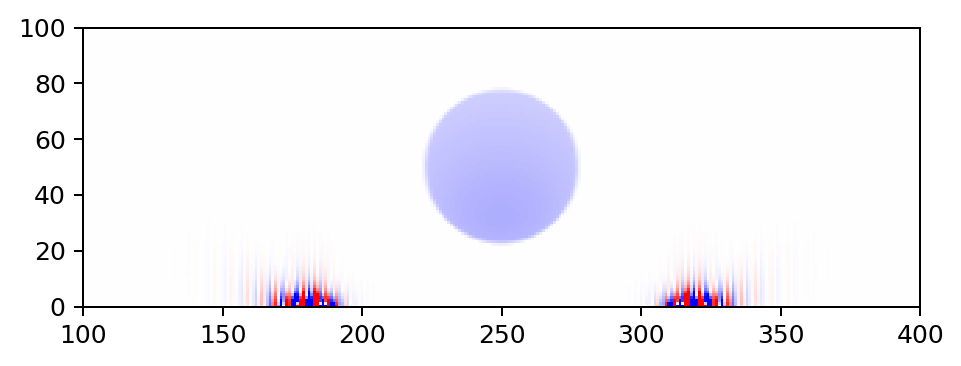

time: 297 ms


In [7]:

fig=plt.figure(2,dpi=180); ax = plt.gca() 
plt.imshow(curBy_gpu[:,250,:].get().T,origin='lower',vmax=.2,vmin=-.2,cmap='bwr')
#plt.colorbar()
plt.xlim([100,400])
plt.ylim([0,100])

In [8]:
curBx_gpu.shape

(501, 501, 501)

time: 1.98 ms


In [9]:
# prepare variables
import cupy.linalg as LA
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
print(BshapeN)
BshapeN = cupy.array(BshapeN)

interp_ratio=1
stride_step=1/interp_ratio

#A = cupy.array([350, 200,  5],dtype=cupy.float32)
#B = cupy.array([670, 200,  5],dtype=cupy.float32)
#C = cupy.array([350, 400,  5],dtype=cupy.float32)

A = cupy.array([ 150,170,  0],dtype=cupy.float32)
B = cupy.array([ 350,170,  0],dtype=cupy.float32)
C = cupy.array([ 150,170,  150],dtype=cupy.float32)

x_range = [150,350]
y_range = [150,350]
z_range = [0,150]
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)

CrossBC_dir = cupy.cross(B-A,C-A)/LA.norm(cupy.cross(B-A,C-A))
z0_dir = cupy.array([0,0,1],dtype=cupy.float32)

if LA.norm((A-B)*(A-C))<1e-9: # orthogonal check

    n = cupy.arange(LA.norm(A-B)*interp_ratio,dtype=cupy.float32) 
    m = cupy.arange(LA.norm(A-C)*interp_ratio,dtype=cupy.float32)
    
    n=n/cupy.max(n)
    m=m/cupy.max(m)

    N,M = cupy.meshgrid(n,m,indexing='ij')
    
    x_arr = A[0]+(B-A)[0]*N+(C-A)[0]*M
    y_arr = A[1]+(B-A)[1]*N+(C-A)[1]*M
    z_arr = A[2]+(B-A)[2]*N+(C-A)[2]*M
   
    xy_shape = x_arr.shape
    
    x_inp = x_arr.flatten()
    y_inp = y_arr.flatten()
    z_inp = z_arr.flatten()
    
    line_len = cupy.zeros(x_inp.shape,cupy.float64)
    N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
    s_len    = cupy.array([1./8.],cupy.float32)
    tol_coef    = cupy.array([1.],cupy.float32)

    (x_start,y_start,z_start, x_end,y_end,z_end,
     Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end
    )=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    
    twist_all = cupy.zeros(x_inp.shape,cupy.float64)
    
    # for GTX 1060
    #blck=(64,1,1)
    #grd = (20,1)

    # for GTX1080ti
    blck=(128,1,1)
    grd = (28,1)
    cupy.cuda.stream.get_current_stream().synchronize()
else:
    print('Init vec not orthogonal')

[501 501 501]
time: 73 ms


In [10]:
import FastQSL
Qube =np.zeros([xy_shape[0],y_i.shape[0],xy_shape[1]],dtype=np.float32)
Twube=np.zeros([xy_shape[0],y_i.shape[0],xy_shape[1]],dtype=np.float32)
Liube=np.zeros([xy_shape[0],y_i.shape[0],xy_shape[1]],dtype=np.float32)
#z_i=z_i*0+20
print(Qube.shape)

(200, 200, 150)
time: 25 ms


In [33]:
pinned_mempool = cupy.get_default_pinned_memory_pool()
for idx_pos_y,y_pos in tqdm.tqdm(enumerate(y_i)):
    
    (x_start,y_start,z_start, x_end,y_end,z_end,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]
    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    
    
    x_inp = x_arr.flatten()
    y_inp = (cupy.zeros_like(x_inp,cupy.float32)+y_pos)
    z_inp = z_arr.flatten()
    
    cupy.cuda.stream.get_current_stream().synchronize()
    # run the big calclation
    TraceAllBline(blck,grd,
                (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
                curBx_gpu,curBy_gpu,curBz_gpu,twist_all,flag_twist,
                x_inp,   y_inp,   z_inp,CrossBC_dir,
                x_start, y_start, z_start, flag_start,
                x_end,   y_end,   z_end,   flag_end,
                Bx_inp,  By_inp,  Bz_inp,  B_flag,
                Bx_start,By_start,Bz_start,
                Bx_end,  By_end,  Bz_end,  
                s_len,N,line_len, tol_coef*0.01))

    cupy.cuda.stream.get_current_stream().synchronize()
    (x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bx_0_arr,    By_0_arr,   Bz_0_arr,   B_flag_arr, twist_all_arr,
         line_len_arr) = FastQSL.ResReshape(xy_shape,
                        x_end,y_end,z_end,flag_end,
                        x_start,y_start,z_start,flag_start,
                        Bx_start,By_start,Bz_start,
                        Bx_end,By_end,Bz_end, 
                        Bx_inp,By_inp,Bz_inp,B_flag,twist_all,line_len)

    Q=FastQSL.QCalcPlane(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
             x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
             Bx_in_arr,   By_in_arr,  Bz_in_arr,
             Bx_out_arr,  By_out_arr, Bz_out_arr,
             Bx_0_arr,    By_0_arr,   Bz_0_arr,    
             B_flag_arr, stride_step)
    stride_this  =  cupy.float32(1./interp_ratio)/8

    (cut_inp_x,   cut_inp_y,   cut_inp_z,
    cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
    cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
    Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
    Bx_start_cut,By_start_cut,Bz_start_cut,
    Bx_end_cut,  By_end_cut,  Bz_end_cut,  
    N_cut,line_len_cut,Bz0_start, Bz0_end)=FastQSL.CookPseudoLine(
         x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bz_0_arr,    B_flag_arr, stride_this)
    
    # run the psuedo correction
    TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
              dummy,dummy,dummy,dummy,flag_twist_false,
            cut_inp_x,   cut_inp_y,   cut_inp_z, z0_dir, # use z0 as norm
            cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
            cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
            Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
            Bx_start_cut,By_start_cut,Bz_start_cut,
            Bx_end_cut,  By_end_cut,  Bz_end_cut,  
            s_len,N_cut,line_len_cut, tol_coef*.1))

    cupy.cuda.stream.get_current_stream().synchronize()    

    (X1,Y1,X2,Y2) = [cupy.zeros(cut_inp_x.shape,dtype=cupy.float32) 
                     for _ in range(4)];

    idx_Z1_cut=(flag_cut_start-1)//2 == 2;  idx_Z2_cut=(flag_cut_end-1)//2 == 2
    idx_Y1_cut=(flag_cut_start-1)//2 == 1;  idx_Y2_cut=(flag_cut_end-1)//2 == 1
    idx_X1_cut=(flag_cut_start-1)//2 == 0;  idx_X2_cut=(flag_cut_end-1)//2 == 0

    # Z plane
    X1[idx_Z1_cut] = cut_start_x[idx_Z1_cut]; Y1[idx_Z1_cut] = cut_start_y[idx_Z1_cut] 
    X2[idx_Z2_cut] = cut_end_x[idx_Z2_cut];   Y2[idx_Z2_cut] = cut_end_y[idx_Z2_cut] 
    # Y plane
    X1[idx_Y1_cut] = cut_start_z[idx_Y1_cut]; Y1[idx_Y1_cut] = cut_start_x[idx_Y1_cut]
    X2[idx_Y2_cut] = cut_end_z[idx_Y2_cut];   Y2[idx_Y2_cut] = cut_end_x[idx_Y2_cut]
    # X plane
    X1[idx_X1_cut] = cut_start_y[idx_X1_cut]; Y1[idx_X1_cut] = cut_start_z[idx_X1_cut]
    X2[idx_X2_cut] = cut_end_y[idx_X2_cut];   Y2[idx_X2_cut] = cut_end_z[idx_X2_cut]

    dx2xc = X2[0::4]-X2[2::4]; dx2yc = X2[1::4]-X2[3::4];
    dy2xc = Y2[0::4]-Y2[2::4]; dy2yc = Y2[1::4]-Y2[3::4];

    dx1xc = X1[0::4]-X1[2::4]; dx1yc = X1[1::4]-X1[3::4];
    dy1xc = Y1[0::4]-Y1[2::4]; dy1yc = Y1[1::4]-Y1[3::4];

    a_cut = (dx2xc*dy1yc-dx2yc*dy1xc);
    b_cut = (dx2yc*dx1xc-dx2xc*dx1yc);
    c_cut = (dy2xc*dy1yc-dy2yc*dy1xc);
    d_cut = (dy2yc*dx1xc-dy2xc*dx1yc);

    bnr_cut = cupy.abs(Bz0_end)/(cupy.abs(Bz0_start))*((1/stride_this/2)**4)
    Qcut = (a_cut**2+b_cut**2+c_cut**2+d_cut**2)*bnr_cut
    Qcut[cupy.where(Qcut<1.0)]=1.0

    cupy.cuda.stream.get_current_stream().synchronize()

    Q_all=cupy.zeros(x_end_arr.shape,dtype=cupy.float32)

    Q_all[1:-1,1:-1]=Q
    Q_all[B_flag_arr==1]=Qcut
    Q_final=Q_all[1:-1,1:-1]

    Qube[:,idx_pos_y,:]=Q_all.get()
    Twube[:,idx_pos_y,:]=twist_all_arr.get()
    Liube[:,idx_pos_y,:]=line_len_arr.get()
    
    cupy.cuda.stream.get_current_stream().synchronize()
    
    (x_start,y_start,z_start, x_end,y_end,z_end,z_inp,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[None for _ in range(16)]
    (B_flag,flag_start,flag_end)=[None for _ in range(3)]
    pinned_mempool.free_all_blocks()

200it [03:49,  1.15s/it]

time: 3min 49s


In [12]:
import plotly
x_i_0 = np.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=np.float32)
y_i_0 = np.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=np.float32)
z_i_0 = np.linspace(*z_range, np.uint(interp_ratio*(z_range[1]-z_range[0])),dtype=np.float32)


x_arr_0,y_arr_0,z_arr_0 = np.meshgrid(x_i_0, y_i_0, z_i_0)

time: 45 ms


In [13]:
Qube.shape

(200, 200, 150)

time: 2.99 ms


In [14]:
from numpy import cos, pi, mgrid
import pyvista as pv

time: 3.32 s


In [15]:
np.savez('../Qube.npz', Qube,x_arr_0,y_arr_0,z_arr_0,Twube)

time: 276 ms


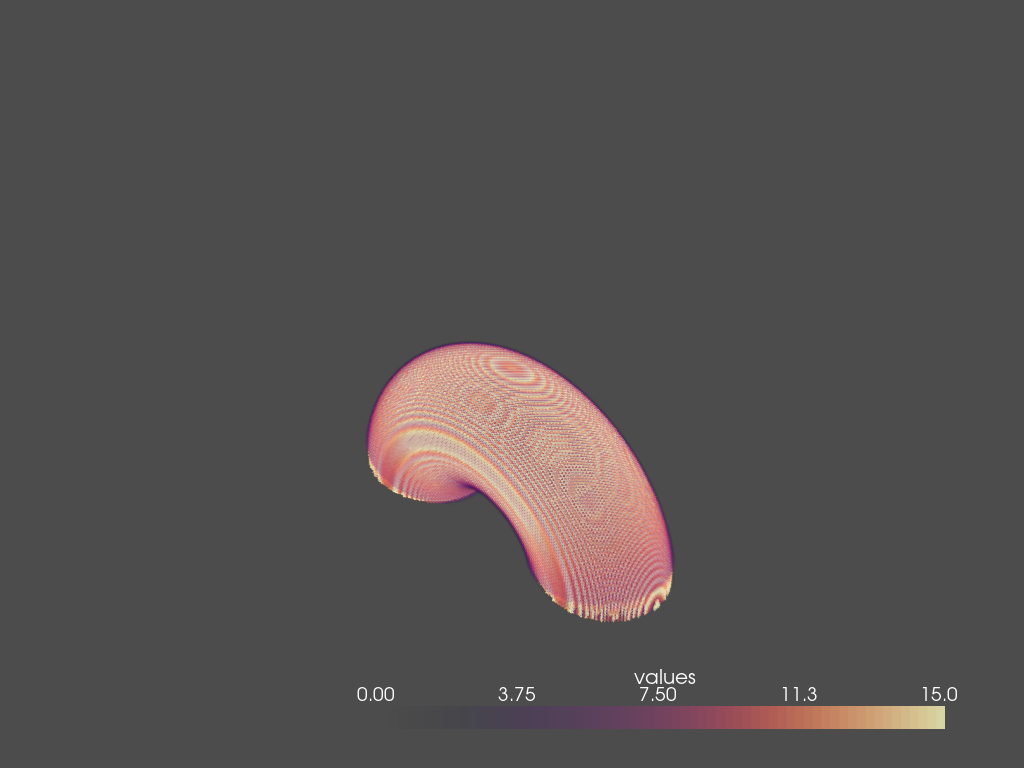

time: 882 ms


In [34]:
opacity = [ 0,0.2,0.4, 0.65, 0.8]
clim = [0, 15]

p = pv.Plotter()
p.add_volume(-Twube, cmap="magma", clim=clim,
             opacity=opacity, opacity_unit_distance=2,)
#p.camera_position = [(-800*2, 1200*2, 666*2),
# (179.5, 299.5, 99.5),
# (0.4, -0.1, 0.9)]
p.show()

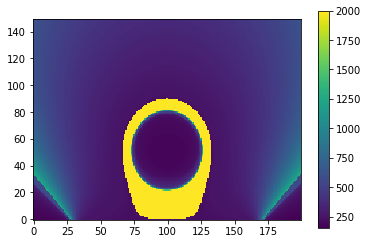

time: 230 ms


In [35]:
plt.imshow((Liube[:,100,:].T),origin='lower',vmax=2000)#,vmax=0.0001,vmin=-0.0001,cmap='bwr')
plt.colorbar()

divide by zero encountered in log10


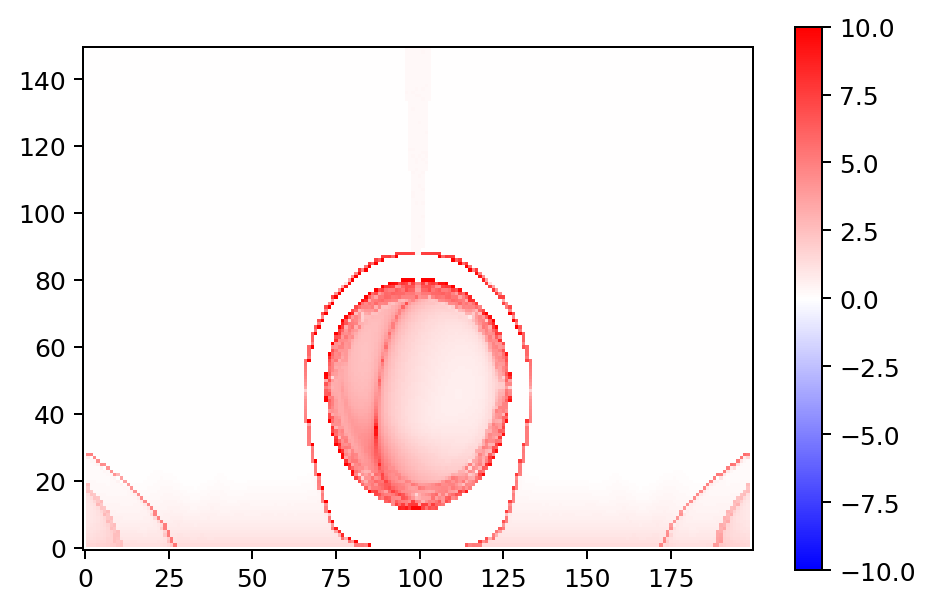

time: 341 ms


In [38]:

fig=plt.figure(2,dpi=180); ax = plt.gca() 
#plt.imshow((Twube[:,100,:].T),origin='lower',vmax=5,vmin=-5,cmap='bwr')

plt.imshow(np.log10(Qube[:,80,:].T),origin='lower',vmax=10,vmin=-10,cmap='bwr')
plt.colorbar()

In [ ]:
#%% Data
grid = pv.StructuredGrid(x_arr_0.flatten(), y_arr_0.flatten(), z_arr_0.flatten())
grid["vol"] = Qube.flatten()
contours = grid.contour([1000000])

#%% Visualization
pv.set_plot_theme('document')
p = pv.Plotter()
p.add_mesh(contours, scalars=contours.points[:, 2], show_scalar_bar=False)
p.show()

In [ ]:
plt.imshow()

In [ ]:
plt.close()

xxlim=None
yylim=None

#xxlim=[400,720]
#yylim=[150,400]
#xxlim=[550,650]
#yylim=[200,270]
#xxlim= [350,670]
#yylim= [200,400]

dpi=180

fig=plt.figure(0,dpi=dpi); ax = plt.gca() 
img=ax.imshow(flag_start_arr.get(),cmap='inferno',origin='lower',vmin=0,
              extent=[*x_range,*y_range],vmax=6)
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(1,dpi=dpi); ax = plt.gca() 
img=ax.imshow((line_len.get().reshape(xy_shape)),cmap='inferno',origin='lower',
              vmin=0,extent=[*x_range,*y_range],vmax=1000)
fig.colorbar(img)
ax.set_title('Length of B-line')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_in_arr.get()/Bz_out_arr.get(),cmap='gray',origin='lower',
              vmax=10,vmin=-10,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_out_arr.get(),cmap='gray',origin='lower',vmax=1000,vmin=-1000,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q.get())*np.sign(Bz_0_arr.get()[1:-1,1:-1])
                *(flag_start_arr.get()[1:-1,1:-1]<=6),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


fig=plt.figure(5,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q.get())*np.sign(Bz_0_arr.get()[1:-1,1:-1])
                *(flag_start_arr.get()[1:-1,1:-1]<=6),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(6,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q_all.get())*(flag_start_arr.get()[1:-1,1:-1]<41),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map-gray')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


In [ ]:
fig=plt.figure(1,dpi=180); ax = plt.gca() 
#img = ax.imshow(np.log((b.get())**2),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
#fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=180); ax = plt.gca() 
img = ax.imshow((B_flag_arr.get()),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)
